In [ ]:
# -*- coding: utf-8 -*-
# Create time: 2025-10-06
# Update time: 2025-11-27

# conda activate benchmark
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap
import os
import glob
plt.rcParams['svg.fonttype'] = 'none'

def plot_dual_umap_from_npz(npz_file, save_dir=None, title=None, figsize=(11, 6.5)):
    """
    从npz文件加载数据并绘制raw和neutralized两个UMAP图
    完全适配figure_celltype_embedding风格
    
    参数:
    npz_file: npz文件路径
    save_dir: 输出目录
    figsize: 图像大小 (单位: inch)
    """
    # 加载数据
    data = np.load(npz_file, allow_pickle=True)
    raw_embeddings = data['raw']
    neutralized_embeddings = data['neutralized']
    semantic_group = data['semantic_group']
    languages = data['languages']
    
    # 从文件名提取模型名称
    filename = os.path.basename(npz_file)
    model_name = filename.replace('embeddings_', '').replace('.npz', '')
    
    print(f"正在为模型 {model_name} 生成UMAP可视化...")
    
    # 全局字体设置 - 完全按照figure_celltype_embedding风格
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 6

    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 计算UMAP
    reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
    umap_raw = reducer.fit_transform(raw_embeddings)
    umap_neutral = reducer.fit_transform(neutralized_embeddings)
    
    # 准备数据
    unique_semantic_groups = np.unique(semantic_group)
    unique_languages = np.unique(languages)

    # 定义语义组的语义描述 - 基于原始sentence_groups
    semantic_labels = {
        0: "Scientific Discovery",  # "The scientist published a groundbreaking discovery."
        1: "Weather Forecast",      # "The rain will stop soon, and the sun will come out."
        2: "Movie Opinion",         # "In my opinion, that movie was a true masterpiece."
        3: "Location Inquiry"       # "Can you tell me where the nearest train station is?"
    }
    
    # 定义语言全称映射
    language_full_names = {
        'en': 'English',
        'es': 'Spanish', 
        'de': 'German',
        'fr': 'French'
    }
    
    # 定义形状映射
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x']
    language_marker_map = {lang: markers[i % len(markers)] for i, lang in enumerate(unique_languages)}
    
    # 设置颜色映射
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_semantic_groups)))
    semantic_color_map = {group: colors[i] for i, group in enumerate(unique_semantic_groups)}
    
    plot_data = [
        (umap_raw, "Raw embedding", axes[0]),
        (umap_neutral, "Language-centered embedding", axes[1]),
    ]
    
    # 绘制所有子图
    for coords, subtitle, ax in plot_data:
        for i in range(len(coords)):
            x, y = coords[i]
            semantic = semantic_group[i]
            language = languages[i]
            
            ax.scatter(x, y, 
                      c=[semantic_color_map[semantic]], 
                      marker=language_marker_map[language],
                      s=30, alpha=0.8, edgecolors='black', linewidth=0.25)
        
        ax.set_title(subtitle, fontsize=7)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # 设置框线宽度
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

    # 调整子图布局，为图例留出空间
    plt.subplots_adjust(bottom=0.33)
    
    # 创建图例 - 使用语义描述和语言全称
    # Semantic Group图例 (颜色) - 放在左侧，使用语义描述
    semantic_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=semantic_color_map[group], markersize=5, alpha=0.9)
                       for group in unique_semantic_groups]
    semantic_legend_labels = [semantic_labels.get(group, f"Group {group}") for group in unique_semantic_groups]
    semantic_legend = fig.legend(semantic_handles, semantic_legend_labels, 
                                title="Semantic Group", 
                                loc='lower center', bbox_to_anchor=(0.34, 0.1),
                                fontsize=5, title_fontsize=6,
                                frameon=False, 
                                ncol=2, columnspacing=1, handletextpad=1)  # 改为2列以适应较长的标签
    
    # Language图例 (形状) - 放在右侧，使用语言全称
    language_handles = [plt.Line2D([0], [0], marker=language_marker_map[lang], color='gray', 
                                  markersize=3, alpha=0.9, linestyle='None')
                       for lang in unique_languages]
    language_legend_labels = [language_full_names.get(lang, lang) for lang in unique_languages]
    language_legend = fig.legend(language_handles, language_legend_labels, title="Language", 
                                loc='lower center', bbox_to_anchor=(0.76, 0.1),
                                fontsize=5, title_fontsize=6,
                                frameon=False,
                                ncol=2, columnspacing=1, handletextpad=1)  # 改为2列以适应较长的标签
    
    # 添加图形标题
    fig.suptitle(title, fontsize=7, y=1.03, fontweight='bold')

    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f'Figure2D&S8_llm_embedding_{model_name}.pdf'), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f'Figure2D&S8_llm_embedding_{model_name}.svg'), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f'Figure2D&S8_llm_embedding_{model_name}.jpg'), dpi=600, bbox_inches="tight")
    
    plt.show()
    return fig, axes

def process_all_npz_files(input_dir, output_dir=None, figsize=(11, 6.5)):
    """
    处理目录中的所有npz文件
    
    参数:
    input_dir: 包含npz文件的目录
    output_dir: 输出目录
    figsize_cm: 图像大小 (单位: cm)
    """
    
    # 查找所有npz文件
    npz_pattern = os.path.join(input_dir, "embeddings_*.npz")
    npz_files = glob.glob(npz_pattern)
    
    if not npz_files:
        print(f"在目录 {input_dir} 中未找到embeddings_*.npz文件")
        return
    
    print(f"找到 {len(npz_files)} 个npz文件")
    
    for npz_file in npz_files:
        try:
            plot_dual_umap_from_npz(npz_file, output_dir, figsize)
        except Exception as e:
            print(f"处理文件 {npz_file} 时出错: {e}")
            continue
    
    print("所有模型处理完成！")


In [2]:
# 设置输入和输出目录
input_directory = "/home/wanglinting/LCBERT/Download/src_zch/results"
output_directory = "/home/wanglinting/scFM/Result/figure/llm_umap"

# cm转换为inch
cm_to_inch = 1 / 2.54


正在为模型 Qwen2-7B-Instruct 生成UMAP可视化...


/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


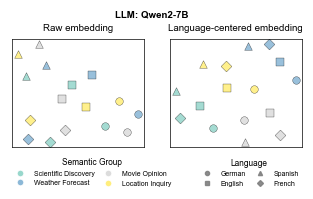

(<Figure size 374.016x196.85 with 2 Axes>,
 array([<Axes: title={'center': 'Raw embedding'}>,
        <Axes: title={'center': 'Language-centered embedding'}>],
       dtype=object))

In [3]:
# 处理某个模型
plot_dual_umap_from_npz(
    "/home/wanglinting/LCBERT/Download/src_zch/results/embeddings_Qwen2-7B-Instruct.npz",
    title="LLM: Qwen2-7B",
    save_dir=output_directory,
    figsize=(9.5*cm_to_inch, 5*cm_to_inch)
)

正在为模型 Qwen2-0.5B-Instruct 生成UMAP可视化...


/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


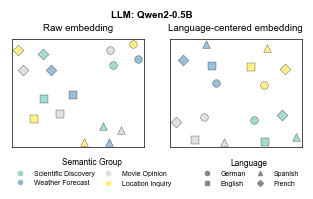

(<Figure size 374.016x196.85 with 2 Axes>,
 array([<Axes: title={'center': 'Raw embedding'}>,
        <Axes: title={'center': 'Language-centered embedding'}>],
       dtype=object))

In [4]:
# 或者单独处理某个模型
plot_dual_umap_from_npz(
    "/home/wanglinting/LCBERT/Download/src_zch/results/embeddings_Qwen2-0.5B-Instruct.npz",
    title="LLM: Qwen2-0.5B",
    save_dir=output_directory,
    figsize=(9.5*cm_to_inch, 5*cm_to_inch)
)

正在为模型 Qwen2-1.5B-Instruct 生成UMAP可视化...


/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


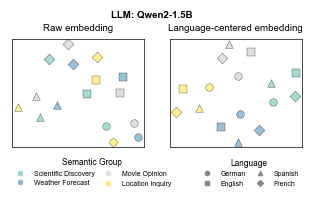

(<Figure size 374.016x196.85 with 2 Axes>,
 array([<Axes: title={'center': 'Raw embedding'}>,
        <Axes: title={'center': 'Language-centered embedding'}>],
       dtype=object))

In [5]:
# 或者单独处理某个模型
plot_dual_umap_from_npz(
    "/home/wanglinting/LCBERT/Download/src_zch/results/embeddings_Qwen2-1.5B-Instruct.npz",
    title="LLM: Qwen2-1.5B",
    save_dir=output_directory,
    figsize=(9.5*cm_to_inch, 5*cm_to_inch)
)

正在为模型 Qwen3-4B 生成UMAP可视化...


/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/wanglinting/Software/anaconda3/envs/benchmark/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


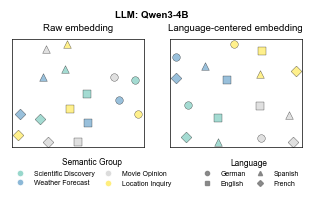

(<Figure size 374.016x196.85 with 2 Axes>,
 array([<Axes: title={'center': 'Raw embedding'}>,
        <Axes: title={'center': 'Language-centered embedding'}>],
       dtype=object))

In [6]:
# 或者单独处理某个模型
plot_dual_umap_from_npz(
    "/home/wanglinting/LCBERT/Download/src_zch/results/embeddings_Qwen3-4B.npz",
    title="LLM: Qwen3-4B",
    save_dir=output_directory,
    figsize=(9.5*cm_to_inch, 5*cm_to_inch)
)